In [1]:
import matplotlib.pyplot as plt

import warnings
from glob import glob #library that helps us search for files

import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


warnings.simplefilter(action="ignore", category=FutureWarning)


In this chapter, we will start by using a simple regression  algorithm, linear regression. We will discuss two different ways to train it:
    
    1. Using a direct closed-form equation computes the model parameters that best fit the model to the training set(i.e., the model parameters that minimize the cost function over the training set).
    
    2. Using an iterative optimization approach called Gradient Descent, that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of GD: Batch-GD, Mini Batch-GD, and Stochastic-GD.

For example, in the first chapter of this book, we looked at a simple regression model of life satisfaction:<br>

       life_satisfaction=c+m*GDP_per_capita,
       
       y=mx+c,
       
This model is just a linear function of the input feature GDP_per_capita(the predictor variable), c and m are the model's parameters. <br>
More generally, a linear model works by taking a weighted average of the input features(predictor variables) plus a constant called the bias term(or intercept) as shown in the eqn below,

       y = c + M1X1 + M2X2 + M3X3 + ..... + MnXn,
       
       where y is the target variable or predicted value,
       n is the number of features,
       M is the model's parameter.
       
       The above eqn can be written ina more vectorized form,
       
       y=ho(x)=0.x,
       
       where 0 is the model's parameter vector, containing the bias term c and the feature weights from M1 to Mn,
       x is instance's feature vector containing x0 to xn, with x0 always equal to 1,
       0.x is dot product of the vectors 0 and x, which is equal to M1X1 + M2X2 + M3X3 + ..... + MnXn,
       ho is the hypothesis function, using the model parameters 0
       
So, how do we train this model, recall that training a model means setting its parameters so the model best fits the training set. For this purpose, we first need a measure of how well or badly the model fits to the training data. The most common performance measure of a regression model is RMSE, Root Mean Square Error. Therefore, to a train a linear regression model, you need to find the value of 0 that best minimizes the RMSE. In practice, it is simpler to minimize the MSE than the RMSE, and it leads to the same result.

       MSE Cost function for a linear regression model,
       MSE(0) = (1/m)(E(0^T * x^i -y^i)^2)
      

**The Normal Equation**

To find the value of 0 that minimizes the cost function, there is a closed-form solution, an equation that gives the result directly. This is called the normal equation,

       0^ = (X^T*X)^-1  X^T  y,
       
       0^ is that value of 0 that minimizes the cost function,
       y is the vector of target variables(from y0 to yn).

In [2]:
'''Lets generate some linear looking data to test this equation'''

X= 2 * np.random.rand(100,1)
y= 4 + 3 * X + np.random.randn(100,1)

In [3]:
X[:5],y[:5]

(array([[1.94620998],
        [1.49646685],
        [1.04759975],
        [1.74183637],
        [1.99234803]]),
 array([[10.32928344],
        [10.61038006],
        [ 6.0538618 ],
        [10.37811924],
        [ 9.96552706]]))

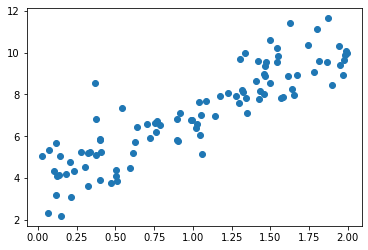

In [4]:
plt.scatter(X,y)

Now, let's compute 0^ using the normal equation. We will use inv() function from Numpy's linear algebra module, np.linalg() to compute the inverse of a matrix and the dot() for matrix multiplication.

In [5]:
x_b=np.c_[np.ones((100,1)),X]
theta_best=np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

The actual function we used to generate this data is, y = 4 + 3xi + gaussian noise. Lets see what the eqn found:

In [6]:
theta_best

array([[3.77307306],
       [3.27259902]])

We would have hoped for c=4 and m=3 instead of c=3.82 and m=3.4. Close enough, but noise made it impossible to recover the exact parameters of the original function.<br>
Now you can make predictions using 0^:

In [7]:
new_X=np.array([[0],[2]])
new_X_b=np.c_[np.ones((2,1)),new_X]
y_predict=new_X_b.dot(theta_best)
y_predict

array([[ 3.77307306],
       [10.31827111]])

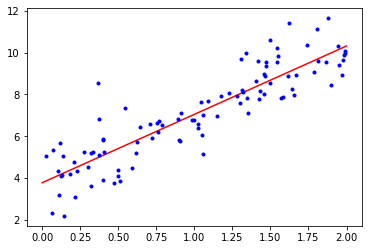

In [8]:
#lets plot this
plt.plot(new_X,y_predict,'r-')
plt.plot(X,y,'b.')

In [9]:
#performing linear regression with scikit learn
lr=LinearRegression()

In [10]:
lr.fit(X,y)

LinearRegression()

In [11]:
lr.coef_,lr.intercept_

(array([[3.27259902]]), array([3.77307306]))

In [12]:
lr.predict(new_X)

array([[ 3.77307306],
       [10.31827111]])

The linearRegression class is based on scipy.linalg.lstsq() function, (least squares).

## GRADIENT DESCENT
It is a very generic optimization algorithm capable of finding the optimal solution to a wide range of problems. It works by tweaking parameters iteratively to minimiza the cost function

**BATCH GRADIENT DESCENT**

In [13]:
learning_rate=0.1

n_iters=500

n_instances=100#number of training examples

In [14]:
#random initialization
theta = np.random.randn(2,1)#this returns an x*x array of normal distribuutions

for iter in range(n_iters):
    #gradient vector of all partial dervative
    gradients = 2/n_instances * x_b.T.dot(x_b.dot(theta) - y)
    #gradient descent step
    theta = theta - learning_rate*gradients

In [15]:
theta

array([[3.77307301],
       [3.27259906]])

We have exactly what the normal equation found.




**STOCHASTIC GRADIENT DESCENT**

In [16]:
#epoch is the passing of the entire data set into the ml algorithm
n_epochs=50

#learning schedule hyperparameters- the function that determines the learning rate at each iteration
t0 , t1=5, 50

def learning_schedule(t):
    return t0/(t + t1)

In [17]:
theta  = np.random.randn(2,1)

for epoch in range(n_epochs):
    
    for i in range(n_instances):
        
        random_index = np.random.randint(n_instances)
        
        xi = x_b[random_index:random_index+1]
        
        yi = y[random_index:random_index+1]
        
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        
        learning_rate = learning_schedule(epoch * n_instances + i)
        
        theta = theta - learning_rate*gradients
theta

array([[3.78027364],
       [3.27984077]])

**STOCHASTIC GRADIENT DESCENT WITH LINEAR REGRESSION**


In [18]:
from sklearn.linear_model import SGDRegressor

In [19]:
sgd_reg=SGDRegressor(max_iter=1000,tol=1e-3,eta0=0.1,penalty=None)
#max_iter=1000 means maximum number of iterations/epochs until the loss drops by or less than  tol=1e-3  in one epoch
#learning rate: eta0=0.1

In [20]:
sgd_reg.fit(X,y)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDRegressor(eta0=0.1, penalty=None)

In [21]:
sgd_reg.coef_,sgd_reg.intercept_

(array([3.32712278]), array([3.78205758]))

## POLYNOMIAL REGRESSION

In [22]:
#LETS GENERATE SOME NON LINEAR DATA
n_instances = 100
x = 6* np.random.rand(n_instances,1)-3

y=0.5 * x**2 + x + 2 + np.random.rand(n_instances,1)

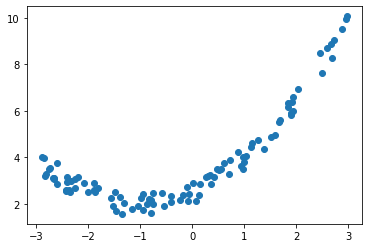

In [23]:
plt.scatter(x,y)

In [24]:
#transforming non linear data
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2,include_bias=False)#degree: degree of polynomial

xpoly=poly.fit_transform(x)

In [25]:
lin_reg=LinearRegression()

In [26]:
lin_reg.fit(xpoly,y)

LinearRegression()

In [27]:
lin_reg.coef_,lin_reg.intercept_

(array([[1.01280057, 0.4861144 ]]), array([2.56943537]))

## RIDGE REGRESSION WITH NORMAL EQUATION

In [28]:
from sklearn.linear_model import Ridge

In [29]:
ridge=Ridge(alpha=1,solver='cholesky')
#cholesky is matrix factorization technique by Andre-Louis cholesky

In [30]:
ridge.fit(x,y)

Ridge(alpha=1, solver='cholesky')

## RIDGE REGRESSION WITH STOCHASTIC GRADIENT DESCENT

In [36]:
from sklearn.linear_model import SGDRegressor

In [37]:
sgd_ridge=SGDRegressor(penalty='l2')#setting the l2 means ridge regression

In [40]:
sgd_ridge.fit(x,y.ravel())

SGDRegressor()

## LASSO REGRESSION WITH NORMAL EQUATION

In [41]:
from sklearn.linear_model import Lasso

In [42]:
lasso=Lasso(alpha=0.1)

In [43]:
lasso.fit(x,y)

Lasso(alpha=0.1)

## LASSO REGRESSION WITH STOCHASTIC GRADIENT DESCENT

In [44]:
sgd_ridge=SGDRegressor(penalty='l1')#setting the l1 means lasso regression

## ELASTIC NET REGRESSION

In [45]:
from sklearn.linear_model import ElasticNet

In [46]:
enet = ElasticNet(alpha=0.1,l1_ratio=0.5)

In [47]:
enet.fit(x,y)

ElasticNet(alpha=0.1)

## EARLY STOPPING

In [72]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [73]:
from sklearn.model_selection import train_test_split

xtrain,xval,ytrain,yval=train_test_split(x,y,test_size=0.3)

In [74]:
#prepare data by polynomial transformation and standard scaling
polyscaler = Pipeline([('poly_features',PolynomialFeatures(degree=90,include_bias=False)),('Std_Scaler',StandardScaler())])

<IPython.core.display.Javascript object>

In [75]:
xtrain_polyscaled=polyscaler.fit_transform(xtrain)
xval_polyscaled=polyscaler.fit_transform(xval)

In [76]:
sgd_reg=SGDRegressor(max_iter=1,tol=-np.infty,warm_start=True,penalty=None,learning_rate='constant',eta0=0.0005)

In [77]:
minimum_val_error = float('inf')

best_epoch=None
best_model=None

In [78]:
for epoch in range(1000):
    sgd_reg.fit(xtrain_polyscaled,ytrain.ravel())
    yval_predict=sgd_reg.predict(xval_polyscaled)
    
    val_error = mean_squared_error(yval,yval_predict)
    
    if val_error< minimum_val_error:
        minimum_val_error=val_error
        best_epoch=epoch
        best_model=clone(sgd_reg)

inf

In [32]:
data=pd.DataFrame({'a':[4,5,6,7,8],'b':['lagos','kano','bauchi','uyo','kebbi']})
tatr=pd.DataFrame({'c':[1,5,3,3,],'b':['lagos','kano','bauchi','kebbi']})

In [33]:
mapc=dict(zip(data['b'],data['a']))
mapc

{'lagos': 4, 'kano': 5, 'bauchi': 6, 'uyo': 7, 'kebbi': 8}

In [34]:
tatr['b'].map(mapc)

0    4
1    5
2    6
3    8
Name: b, dtype: int64

In [35]:
x=dat['b']
y=tatr['a']
z=tatr['b']

NameError: name 'dat' is not defined

In [ ]:
if x==z:
    dat=dat.replace(x,y)
dat

In [ ]:
for i in dat['b'].values:
    for h in tatr['b'].values:
        if i==h:
            dat['b']=dat.replace(i,tatr['a'],inplace=True)

In [ ]:
dat

In [ ]:
for i in dat['b']:
    for a in tatr['b']:
        if i==j:
            print(dat['b'].str.replace(i,tatr['a'].values))

In [ ]:
dat